# BipedalWalker-v2 with PPO, Vectorized Environment
In this notebook, you will implement a PPO agent with OpenAI Gym's BipedalWalker-v2 environment.

### 1. Create Vectorized Environment

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from  collections  import deque
import time
from model import Policy
from ppo import ppo_agent
from storage import RolloutStorage
from utils import get_render_func, get_vec_normalize
from envs import make_vec_envs
from parallelEnv import parallelEnv
import matplotlib.pyplot as plt
%matplotlib inline

print('gym version: ', gym.__version__)
print('torch version: ', torch.__version__)

seed = 0 
gamma=0.99
num_processes=16 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

envs = parallelEnv('BipedalWalker-v2', n=num_processes, seed=seed)

## make_vec_envs -cannot find context for 'forkserver'
## forkserver is only available in Python 3.4+ and only on some Unix platforms (not on Windows).
## envs = make_vec_envs('BipedalWalker-v2', \
##                    seed + 1000, num_processes,
##                    None, None, False, device='cpu', allow_early_resets=False)

max_steps = envs.max_steps
print('max_steps: ', max_steps)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)


gym version:  0.13.1
torch version:  1.0.1
device:  cuda:0
max_steps:  1600


### 2. Instantiate Model, Agent and Storage

Initialize the Policy (model MLPBase), PPO Agent and Rollout Storage.

In [2]:
## model Policy uses MLPBase
policy = Policy(envs.observation_space.shape, envs.action_space,\
        base_kwargs={'recurrent': False})

policy.to(device)

agent = ppo_agent(actor_critic=policy, ppo_epoch=16, num_mini_batch=16,\
                lr=0.001, eps=1e-5, max_grad_norm=0.5)

rollouts = RolloutStorage(num_steps=max_steps, num_processes=num_processes, \
                        obs_shape=envs.observation_space.shape, action_space=envs.action_space, \
                        recurrent_hidden_state_size=policy.recurrent_hidden_state_size)

obs = envs.reset()
print('type obs: ', type(obs), ', shape obs: ', obs.shape)
obs_t = torch.tensor(obs)
print('type obs_t: ', type(obs_t), ', shape obs_t: ', obs_t.shape)

rollouts.obs[0].copy_(obs_t)
rollouts.to(device)


type obs:  <class 'numpy.ndarray'> , shape obs:  (16, 24)
type obs_t:  <class 'torch.Tensor'> , shape obs_t:  torch.Size([16, 24])


### 3.Save model function

In [3]:
def save(model, directory, filename, suffix):
    torch.save(model.base.actor.state_dict(), '%s/%s_actor_%s.pth' % (directory, filename, suffix))
    torch.save(model.base.critic.state_dict(), '%s/%s_critic_%s.pth' % (directory, filename, suffix))
    torch.save(model.base.critic_linear.state_dict(), '%s/%s_critic_linear_%s.pth' % (directory, filename, suffix))
    
limits = [-300, -160, -100, -70, -50, 0, 20, 30, 40, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits)-1):
        if j > limits[i] and j < limits[i+1]:
            suf = str(limits[i+1])
            break
        
        i_last = len(limits)-1    
        if  j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf      

### 4. Train the Agent  with Vectorized Environment

In [4]:
num_updates=1000000
gamma = 0.99
tau=0.95
save_interval=30
log_interval= 1 

def ppo_vec_env_train(envs, agent, policy, num_processes, num_steps, rollouts):
    
    time_start = time.time()
    
    n=len(envs.ps)    
    envs.reset()
    
    # start all parallel agents
    print('Number of agents: ', n)
    envs.step([[1]*4]*n)
    
    indices = []
    for i  in range(n):
        indices.append(i)
     
    s = 0
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    for i_episode in range(num_updates):
        
        total_reward = np.zeros(n)
        timestep = 0
        
        for timestep in range(num_steps):

            with torch.no_grad():
                value, actions, action_log_prob, recurrent_hidden_states = \
                   policy.act(
                        rollouts.obs[timestep],
                        rollouts.recurrent_hidden_states[timestep],
                        rollouts.masks[timestep])
                
            obs, rewards, done, infos = envs.step(actions.cpu().detach().numpy())
            
            total_reward += rewards  ## this is the list by agents
                        
            # If done then clean the history of observations.
            masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
            obs_t = torch.tensor(obs)
            ## Add one dimnesion to tensor, otherwise does not work
            ## This is (unsqueeze(1)) solution for:
            ## RuntimeError: The expanded size of the tensor (1) must match the existing size...
            rewards_t = torch.tensor(rewards).unsqueeze(1)
            rollouts.insert(obs_t, recurrent_hidden_states, actions, action_log_prob, \
                value, rewards_t, masks)
                    
        avg_total_reward = np.mean(total_reward)
        scores_deque.append(avg_total_reward)
        scores_array.append(avg_total_reward)
                
        with torch.no_grad():
            next_value = policy.get_value(rollouts.obs[-1],
                            rollouts.recurrent_hidden_states[-1],
                            rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, gamma, tau)

        agent.update(rollouts)

        rollouts.after_update()
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        if i_episode > 0 and i_episode % save_interval == 0:
            print('Saving model, i_episode: ', i_episode, '\n')
            suf = return_suffix(avg_score)
            save(policy, 'dir_save', 'we0', suf)
            #save_venv(policy, 'dir_save_VecEnv', 'final')

        
        if i_episode % log_interval == 0 and len(scores_deque) > 1:            
            prev_s = s
            s = (int)(time.time() - time_start)
            t_del = s - prev_s
            print('Ep. {}, Timesteps {}, Score.Agents: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}, \
Interval: {:02}:{:02}'\
                   .format(i_episode, timestep+1, \
                        avg_total_reward, avg_score, s//3600, s%3600//60, s%60, t_del%3600//60, t_del%60)) 
    
        if len(scores_deque) == 100 and np.mean(scores_deque) > 300.5:   
        # if np.mean(scores_deque) > 20:   
            print('Environment solved with Average Score: ',  np.mean(scores_deque) )
            break
    
    
    return scores_array, avg_scores_array
            

In [5]:
scores, avg_scores = ppo_vec_env_train(envs, agent, policy, num_processes, max_steps, rollouts)


Number of agents:  16
Ep. 1, Timesteps 1600, Score.Agents: -621.02, Avg.Score: -967.44, Time: 00:00:48, Interval: 00:48
Ep. 2, Timesteps 1600, Score.Agents: -618.29, Avg.Score: -851.06, Time: 00:01:11, Interval: 00:23
Ep. 3, Timesteps 1600, Score.Agents: -530.05, Avg.Score: -770.80, Time: 00:01:33, Interval: 00:22
Ep. 4, Timesteps 1600, Score.Agents: -316.62, Avg.Score: -679.97, Time: 00:01:54, Interval: 00:21
Ep. 5, Timesteps 1600, Score.Agents: -256.20, Avg.Score: -609.34, Time: 00:02:14, Interval: 00:20
Ep. 6, Timesteps 1600, Score.Agents: -274.00, Avg.Score: -561.43, Time: 00:02:35, Interval: 00:21
Ep. 7, Timesteps 1600, Score.Agents: -238.21, Avg.Score: -521.03, Time: 00:02:56, Interval: 00:21
Ep. 8, Timesteps 1600, Score.Agents: -207.62, Avg.Score: -486.21, Time: 00:03:17, Interval: 00:21
Ep. 9, Timesteps 1600, Score.Agents: -175.54, Avg.Score: -455.14, Time: 00:03:37, Interval: 00:20
Ep. 10, Timesteps 1600, Score.Agents: -147.44, Avg.Score: -427.17, Time: 00:03:58, Interval: 00:

Ep. 84, Timesteps 1600, Score.Agents: 64.69, Avg.Score: -111.40, Time: 00:29:08, Interval: 00:20
Ep. 85, Timesteps 1600, Score.Agents: 58.87, Avg.Score: -109.42, Time: 00:29:29, Interval: 00:21
Ep. 86, Timesteps 1600, Score.Agents: 49.08, Avg.Score: -107.60, Time: 00:29:49, Interval: 00:20
Ep. 87, Timesteps 1600, Score.Agents: 58.61, Avg.Score: -105.71, Time: 00:30:09, Interval: 00:20
Ep. 88, Timesteps 1600, Score.Agents: 66.82, Avg.Score: -103.77, Time: 00:30:30, Interval: 00:21
Ep. 89, Timesteps 1600, Score.Agents: 79.53, Avg.Score: -101.73, Time: 00:30:50, Interval: 00:20
Saving model, i_episode:  90 

Ep. 90, Timesteps 1600, Score.Agents: 65.72, Avg.Score: -99.89, Time: 00:31:10, Interval: 00:20
Ep. 91, Timesteps 1600, Score.Agents: 85.11, Avg.Score: -97.88, Time: 00:31:30, Interval: 00:20
Ep. 92, Timesteps 1600, Score.Agents: 66.34, Avg.Score: -96.11, Time: 00:31:51, Interval: 00:21
Ep. 93, Timesteps 1600, Score.Agents: 77.33, Avg.Score: -94.27, Time: 00:32:11, Interval: 00:20
Ep.

Ep. 168, Timesteps 1600, Score.Agents: 195.10, Avg.Score: 125.24, Time: 00:57:29, Interval: 00:21
Ep. 169, Timesteps 1600, Score.Agents: 198.95, Avg.Score: 127.11, Time: 00:57:49, Interval: 00:20
Ep. 170, Timesteps 1600, Score.Agents: 220.08, Avg.Score: 129.10, Time: 00:58:09, Interval: 00:20
Ep. 171, Timesteps 1600, Score.Agents: 213.32, Avg.Score: 130.89, Time: 00:58:30, Interval: 00:21
Ep. 172, Timesteps 1600, Score.Agents: 222.26, Avg.Score: 132.81, Time: 00:58:50, Interval: 00:20
Ep. 173, Timesteps 1600, Score.Agents: 208.55, Avg.Score: 134.39, Time: 00:59:11, Interval: 00:21
Ep. 174, Timesteps 1600, Score.Agents: 219.82, Avg.Score: 135.97, Time: 00:59:32, Interval: 00:21
Ep. 175, Timesteps 1600, Score.Agents: 219.89, Avg.Score: 137.62, Time: 00:59:52, Interval: 00:20
Ep. 176, Timesteps 1600, Score.Agents: 211.71, Avg.Score: 139.15, Time: 01:00:12, Interval: 00:20
Ep. 177, Timesteps 1600, Score.Agents: 223.40, Avg.Score: 140.70, Time: 01:00:32, Interval: 00:20
Ep. 178, Timesteps 1

Ep. 251, Timesteps 1600, Score.Agents: 262.84, Avg.Score: 234.71, Time: 01:25:39, Interval: 00:20
Ep. 252, Timesteps 1600, Score.Agents: 256.09, Avg.Score: 235.51, Time: 01:25:59, Interval: 00:20
Ep. 253, Timesteps 1600, Score.Agents: 262.34, Avg.Score: 236.31, Time: 01:26:19, Interval: 00:20
Ep. 254, Timesteps 1600, Score.Agents: 269.85, Avg.Score: 237.04, Time: 01:26:39, Interval: 00:20
Ep. 255, Timesteps 1600, Score.Agents: 278.74, Avg.Score: 237.97, Time: 01:27:00, Interval: 00:21
Ep. 256, Timesteps 1600, Score.Agents: 269.22, Avg.Score: 238.75, Time: 01:27:21, Interval: 00:21
Ep. 257, Timesteps 1600, Score.Agents: 276.96, Avg.Score: 239.50, Time: 01:27:41, Interval: 00:20
Ep. 258, Timesteps 1600, Score.Agents: 275.01, Avg.Score: 240.28, Time: 01:28:01, Interval: 00:20
Ep. 259, Timesteps 1600, Score.Agents: 260.99, Avg.Score: 240.86, Time: 01:28:22, Interval: 00:21
Ep. 260, Timesteps 1600, Score.Agents: 259.19, Avg.Score: 241.44, Time: 01:28:42, Interval: 00:20
Ep. 261, Timesteps 1

Ep. 334, Timesteps 1600, Score.Agents: 294.96, Avg.Score: 280.45, Time: 01:53:48, Interval: 00:21
Ep. 335, Timesteps 1600, Score.Agents: 297.90, Avg.Score: 280.74, Time: 01:54:08, Interval: 00:20
Ep. 336, Timesteps 1600, Score.Agents: 300.45, Avg.Score: 281.04, Time: 01:54:29, Interval: 00:21
Ep. 337, Timesteps 1600, Score.Agents: 302.93, Avg.Score: 281.35, Time: 01:54:50, Interval: 00:21
Ep. 338, Timesteps 1600, Score.Agents: 292.29, Avg.Score: 281.77, Time: 01:55:10, Interval: 00:20
Ep. 339, Timesteps 1600, Score.Agents: 302.98, Avg.Score: 282.26, Time: 01:55:30, Interval: 00:20
Ep. 340, Timesteps 1600, Score.Agents: 288.82, Avg.Score: 282.45, Time: 01:55:51, Interval: 00:21
Ep. 341, Timesteps 1600, Score.Agents: 286.83, Avg.Score: 282.64, Time: 01:56:11, Interval: 00:20
Ep. 342, Timesteps 1600, Score.Agents: 308.04, Avg.Score: 283.03, Time: 01:56:31, Interval: 00:20
Ep. 343, Timesteps 1600, Score.Agents: 283.99, Avg.Score: 283.38, Time: 01:56:52, Interval: 00:21
Ep. 344, Timesteps 1

Ep. 417, Timesteps 1600, Score.Agents: 300.34, Avg.Score: 297.51, Time: 02:22:04, Interval: 00:20
Ep. 418, Timesteps 1600, Score.Agents: 285.32, Avg.Score: 297.35, Time: 02:22:25, Interval: 00:21
Ep. 419, Timesteps 1600, Score.Agents: 302.57, Avg.Score: 297.64, Time: 02:22:45, Interval: 00:20
Saving model, i_episode:  420 

Ep. 420, Timesteps 1600, Score.Agents: 305.35, Avg.Score: 297.68, Time: 02:23:05, Interval: 00:20
Ep. 421, Timesteps 1600, Score.Agents: 306.09, Avg.Score: 297.72, Time: 02:23:26, Interval: 00:21
Ep. 422, Timesteps 1600, Score.Agents: 300.48, Avg.Score: 297.68, Time: 02:23:46, Interval: 00:20
Ep. 423, Timesteps 1600, Score.Agents: 304.90, Avg.Score: 297.70, Time: 02:24:07, Interval: 00:21
Ep. 424, Timesteps 1600, Score.Agents: 278.19, Avg.Score: 297.49, Time: 02:24:28, Interval: 00:21
Ep. 425, Timesteps 1600, Score.Agents: 301.05, Avg.Score: 297.44, Time: 02:24:48, Interval: 00:20
Ep. 426, Timesteps 1600, Score.Agents: 299.23, Avg.Score: 297.40, Time: 02:25:08, Inte

In [6]:
save(model=policy,directory='dir_save',filename='we0',suffix='final')

length of scores:  451 , len of avg_scores:  451


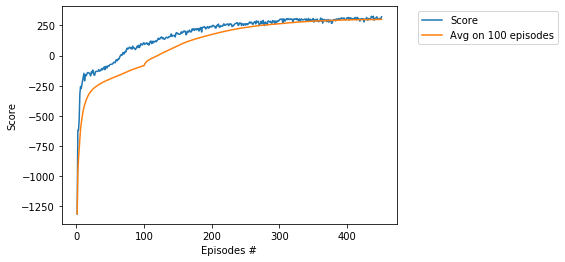

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [8]:
#--------------- make_vec_envs ----------------
## we continue with the same model, model Policy uses MLPBase, but with new environment env_venv

device = torch.device("cpu")
print('device: ', device)

seed = 0 
num_processes=1  

env_venv = make_vec_envs('BipedalWalker-v2', \
                    seed + 1000, num_processes,
                    None, None, False, device='cpu', allow_early_resets=False)

policy = policy.to(device)

print('env_venv.observation_space.shape: ', env_venv.observation_space.shape, \
      ', len(obs_shape): ', len(env_venv.observation_space.shape))
print('env_venv.action_space: ',  env_venv.action_space, \
      ', action_space.shape[0]: ', env_venv.action_space.shape[0])


device:  cpu
env_venv.observation_space.shape:  (24,) , len(obs_shape):  1
env_venv.action_space:  Box(4,) , action_space.shape[0]:  4


In [9]:
## No CUDA, only CPU

def play_VecEnv(env, model, num_episodes):

    obs = env.reset()
    obs = torch.Tensor(obs)
    obs = obs.float()
        
    recurrent_hidden_states = torch.zeros(1, model.recurrent_hidden_state_size)
    
    masks = torch.zeros(1, 1)
    
    scores_deque = deque(maxlen=100)

    render_func = get_render_func(env)
        
    for i_episode in range(1, num_episodes+1):     

        time_start = time.time()
        total_reward = np.zeros(num_processes)
        timestep = 0

        while True:
        
            with torch.no_grad():
                value, action, _, recurrent_hidden_states = \
                    model.act(obs, recurrent_hidden_states, masks, \
                    deterministic=False) # obs = state

            render_func()
            
            obs, reward, done, _ = env.step(action)
            obs = torch.Tensor(obs)
            obs = obs.float()

            reward = reward.detach().numpy()
            
            masks.fill_(0.0 if done else 1.0)
            
            total_reward += reward[0]
        
            #if timestep < 800:
            #    print('timestep: ', timestep, 'reward: ', reward[0])
            
            timestep += 1
            
            if timestep + 1 == 1600: ##   envs.max_steps:
                break

        s = (int)(time.time() - time_start)
        
        scores_deque.append(total_reward[0])
        
        avg_score = np.mean(scores_deque)
                    
        print('Episode {} \tScore: {:.2f}, Avg.Score: {:.2f}, \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, total_reward[0], avg_score,  s//3600, s%3600//60, s%60))  


In [10]:
play_VecEnv(env=env_venv, model=policy, num_episodes=5)

Episode 1 	Score: 345.16, Avg.Score: 345.16, 	Time: 00:00:29
Episode 2 	Score: 312.54, Avg.Score: 328.85, 	Time: 00:00:27
Episode 3 	Score: 339.16, Avg.Score: 332.29, 	Time: 00:00:27
Episode 4 	Score: 303.27, Avg.Score: 325.03, 	Time: 00:00:27
Episode 5 	Score: 342.91, Avg.Score: 328.61, 	Time: 00:00:27


In [19]:
#env_venv.close()
#obs = env_venv.reset()
#obs.close()
#env_venv.close()

In [ ]:
#def load(model):
#    model.base.actor.load_state_dict(torch.load('dir_save_VecEnv\we0_actor_final.pth'))
#    model.base.critic.load_state_dict(torch.load('dir_save_VecEnv\we0_critic_final.pth'))
#    model.base.critic_linear.load_state_dict(torch.load('dir_save_VecEnv\we0_critic_linear_final.pth'))

#def load_venv(model):
#    model.base, ob_rms = \
#            torch.load('dir_save_VecEnv\weights_venv_final.pth')


# load(model=policy)    
# load_venv(model=policy)
# play_episode_parallelEnv(envs=envs, model=policy)